In [1]:
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode,  iplot
import plotly.express as px
import json
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from segregation.singlegroup import absolute_clustering, dissim, interaction,absolute_concentration
import geopandas as gpd
import plotly.io as pio
from shapely.geometry import Point, MultiPoint
from scipy.spatial.distance import cdist
from shapely.ops import transform
from functools import partial
import pyproj
import pickle
from pyproj import Proj, transform

In this notebook, we put together the data from different sources to create the independent and dependent variables for Bayesian modeling

### 1. Immigrant and overall population in census tracts

In [2]:
#Read data for all years
directory = './data/residents_by_cob/ine/'

file_names = os.listdir(directory)
csv_files = [file for file in file_names if file.endswith('.csv')]

dfs = []
for file in csv_files:
    file_path = os.path.join(directory, file)
    df = pd.read_csv(file_path,sep='\t',thousands=r'.')
    df['year'] = file.replace('.csv', '')
    dfs.append(df)

# Concatenate all DataFrames
big_df = pd.concat(dfs, ignore_index=True)

In [3]:
big_df=big_df[(big_df.Sexo=='Ambos Sexos') & (big_df['Sección']!='TOTAL')]
big_df=big_df.drop('Sexo',axis=1)

In [4]:
#Add total census population as a different column
census_pop = big_df[big_df['País de nacimiento']=='Total Población']
census_pop=census_pop.drop('País de nacimiento',axis=1).rename(columns={'Total':'census_total_pob'})
big_df=big_df.merge(census_pop, on=['Sección','year'], how='left')
big_df=big_df[big_df['País de nacimiento']!='Total Población']

In [5]:
#Column names
big_df.columns=['cusec','cob','population','year','census_total_pop']
big_df=big_df[['year','cusec','cob','population','census_total_pop']]

In [6]:
big_df.population=big_df.population.astype(int)
big_df.census_total_pop=big_df.census_total_pop.astype(int)

In [7]:
#Make corrections in country names
big_df.cob=big_df.cob.replace({'República Dominicana':'Rep. Dominicana'})

In [8]:
big_df.cusec=big_df.cusec.astype(int)

In [9]:
#Use a crosswalk file that matches cusecs with corresponding district etc.
crosswalk=pd.read_csv('./data/geography/census_tracts_muns_districts.csv')

In [10]:
#Barcelona Province
crosswalk=crosswalk[crosswalk.NPRO=='Barcelona']

In [11]:
#Select municipalities
muns_of_comarca=['Barcelona',"Hospitalet de Llobregat, L'",'Badalona','Santa Coloma de Gramenet','Sant Adrià de Besòs']
crosswalk=crosswalk[crosswalk.NMUN.isin(muns_of_comarca)]

In [12]:
comarca=big_df.merge(crosswalk, left_on='cusec',right_on='CUSEC',how='inner')

In [13]:
#Note: for 2021, we're working with 1520 cusecs, although in 2022 there are 2 more cusecs
comarca[comarca.year=='2021'].cusec.nunique()

1520

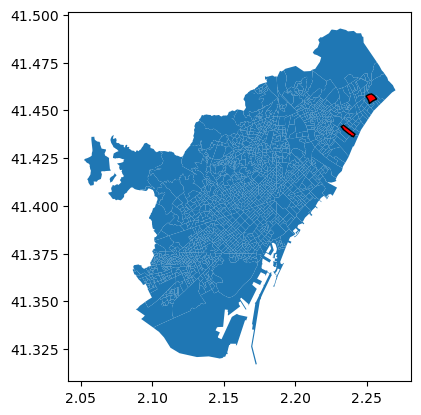

In [14]:
#We'll not have these 2 cusecs in 2021
set(comarca.cusec.unique()) - set(comarca[comarca.year=='2021'].cusec.unique())
gdf = gpd.read_file('./data/geography/cusecs/comarca_reduced.shp')
gdf.plot()
selected_tracts_gdf = gdf[gdf.CUSEC.isin(['0801503015', '0801505008'])]
selected_tracts_gdf.plot(color='red', edgecolor='black', ax=plt.gca())
plt.show()

In [15]:
#Most of the other data is for 2021 - let's keep only that year
comarca=comarca[comarca.year=='2021']

Select TOP 20 foreign nationalities

In [16]:
comarca.groupby('cob').population.sum().reset_index().sort_values('population',ascending=False).head(30)

cob  population
14         Nacidos en España     1653842
15  Nacidos en el Extranjero      627125
27             Total América      328339
28                Total Asia      119967
31       Total Unión Europea       81674
32              Total África       52604
30     Total Resto de Europa       43605
10                   Ecuador       42469
17                  Pakistán       39291
19                      Perú       39089
13                 Marruecos       36629
8                   Colombia       35932
2                  Argentina       34907
7                      China       30225
35                 Venezuela       29752
3                    Bolivia       25164
23           Rep. Dominicana       24491
12                    Italia       22420
11                   Francia       18667
4                     Brasil       16147
25                     Rusia       10268
22               Reino Unido        9516
6                      Chile        9316
24                   Rumanía        8820
0                   Alemania        7932
18                  Paraguay        7808
9                       Cuba        7377
33                   Ucrania        6961
34                   Uruguay        6388
21                  Portugal        4110

In [17]:
top20=['Ecuador', 'Perú', 'Pakistán', 'Argentina', 'Colombia', 'Marruecos',
       'Venezuela', 'China', 'Bolivia', 'Rep. Dominicana', 'Italia', 'Francia',
       'Brasil', 'Rusia', 'Reino Unido', 'Chile', 'Rumanía', 'Alemania',
       'Paraguay', 'Cuba']
comarca=comarca[comarca.cob.isin(top20)]

### 2. Mean Income

In [18]:
renta = pd.read_csv('./data/renta_media/renta_media_2021.csv',sep='\t', encoding='latin-1',thousands=r'.')

In [19]:
#Extract the numbers from Secciones
renta['cusec']=renta.Secciones.str[:10]
renta=renta[['cusec','Total']].rename(columns={'Total':'demog_avg_income'})
renta.cusec=renta.cusec.astype(int)

In [20]:
renta.head()

cusec  demog_avg_income
0  800101001           14486.0
1  800101002           13995.0
2  800101003           18269.0
3  800101004           16169.0
4  800101005           14131.0

In [21]:
comarca=comarca.merge(renta, on='cusec', how='left')

### 3. Neighborhood demographics

In [22]:
demografia = pd.read_csv('./data/demografia_secciones/demografia_secciones_2021.csv', encoding='latin-1')

In [23]:
#Add cusec based on the 5 columns
demografia['cusec'] = (demografia.cpro.astype(str).apply(lambda x: x.zfill(2)) +
          demografia.cmun.astype(str).apply(lambda x: x.zfill(3)) +
          demografia.dist.astype(str).apply(lambda x: x.zfill(2)) +
          demografia.secc.astype(str).apply(lambda x: x.zfill(3)))

In [24]:
#Highlight potentially interesting variables, using the variables description file
#When the percentages add up to 100%, we can leave one category out (e.g. Males)
demografia['demog_female']=demografia['t2_1']
demografia['demog_mean_age']=demografia['t3_1'] 
demografia['demog_age_16_64']=demografia['t4_2']
demografia['demog_age_64plus']=demografia['t4_3']
demografia['demog_uni_degree']=demografia['t9_1']
demografia['demog_unemployed']=demografia['t10_1']
demografia['demog_employed']=demografia['t11_1']
demografia['demog_retired']=demografia['t14_1']
demografia['demog_student']=demografia['t16_1']
demografia['demog_married']=demografia['t17_2']
demografia['housing_total_stock']=demografia['t18_1']
   #Housing variables: make it percentage
demografia['housing_owned']=demografia['t20_1']/demografia['t18_1']
demografia['housing_rented']=demografia['t20_2']/demografia['t18_1']
   #HH variables: make it percentage
demografia['demog_hh_1p']=demografia['t22_1']/demografia['t21_1']
demografia['demog_hh_3p']=demografia['t22_3']/demografia['t21_1']
demografia['demog_hh_4p']=demografia['t22_4']/demografia['t21_1']
demografia['demog_hh_5p+']=demografia['t22_5']/demografia['t21_1']

In [25]:
demografia=demografia[['cusec', 'demog_female', 'demog_mean_age', 'demog_age_16_64', 'demog_age_64plus',
    'demog_uni_degree', 'demog_unemployed', 'demog_employed', 'demog_retired',
    'demog_student', 'demog_married', 'housing_total_stock', 'housing_owned',
    'housing_rented', 'demog_hh_1p', 'demog_hh_3p', 'demog_hh_4p', 'demog_hh_5p+']]

In [26]:
demografia.head()

cusec  demog_female  demog_mean_age  demog_age_16_64  \
0  0400101001        0.4857         49.4994           0.6008   
1  0400201001        0.4719         49.4636           0.6287   
2  0400301001        0.5086         45.0789           0.6789   
3  0400301002        0.5014         40.2112           0.6912   
4  0400301003        0.5087         38.1048           0.7051   

   demog_age_64plus  demog_uni_degree  demog_unemployed  demog_employed  \
0            0.2944            0.2163            0.1951          0.3768   
1            0.2822            0.1812            0.2052          0.3614   
2            0.2002            0.2356            0.1576          0.4686   
3            0.1297            0.2230            0.1251          0.5451   
4            0.1065            0.1720            0.1439          0.5805   

   demog_retired  demog_student  demog_married  housing_total_stock  \
0         0.2899         0.0629         0.4524               1076.0   
1         0.2754         0.0571         0.4678                921.0   
2         0.1728         0.0903         0.4315                395.0   
3         0.1224         0.0869         0.4340                789.0   
4         0.1036         0.0832         0.3960               1117.0   

   housing_owned  housing_rented  demog_hh_1p  demog_hh_3p  demog_hh_4p  \
0       0.366171        0.074349     0.350352     0.158451     0.128521   
1       0.465798        0.096634     0.413379     0.159520     0.114923   
2       0.648101        0.073418     0.220447     0.204473     0.182109   
3       0.678074        0.048162     0.190096     0.222045     0.246006   
4       0.627574        0.073411     0.261324     0.217189     0.202091   

   demog_hh_5p+  
0      0.042254  
1      0.029160  
2      0.118211  
3      0.092652  
4      0.069686

In [27]:
demografia.cusec = demografia.cusec.astype('int64')

In [28]:
comarca=comarca.merge(demografia, on='cusec', how='left')

### 4. Housing market

In [29]:
hab1 = pd.read_csv('./data/censo_habitatge/tipo_y_ano_construccion_2021.csv', sep=';')
hab2 = pd.read_csv('./data/censo_habitatge/tipo_y_edificio_plantas_2021.csv', sep=';')
hab3 = pd.read_csv('./data/censo_habitatge/tipo_y_superficie_2021.csv', sep=';')

In [30]:
#Construction year
hab1=hab1.groupby(['secció censal','any de construcció']).valor.sum().reset_index()\
    .pivot(index='secció censal', columns='any de construcció', values='valor')
   #Make smaller bins (percentage)
hab1['housing_constr_bef_1940']=(hab1['abans de 1900'] + hab1['de 1900 a 1920'] + hab1['de 1921 a 1940'])/hab1.total
hab1['housing_constr_aft_2000']=(hab1['de 2001 a 2010'] + hab1['de 2011 a 2020'])/hab1.total
hab1['housing_constr_1980_2000']=(hab1['de 1981 a 1990'] + hab1['de 1991 a 2000'])/hab1.total
hab1=hab1.reset_index().rename(columns={'secció censal':'cusec'})

In [31]:
#Number of floors
hab2=hab2.groupby(['secció censal',"nombre de plantes de l'edifici"]).valor.sum().reset_index()\
    .pivot(index='secció censal', columns="nombre de plantes de l'edifici", values='valor')
   #Make smaller bins (percentage)
hab2['housing_floor_7_plus']=(hab2['7 plantes']+hab2['8 plantes']+hab2['9 plantes']+hab2['10 plantes o més'])/hab2.total
hab2['housing_floor_1']=(hab2['1 planta'])/hab2.total
hab2=hab2.reset_index().rename(columns={'secció censal':'cusec'})

In [32]:
#Housing size
hab3=hab3.groupby(['secció censal',"superfície útil"]).valor.sum().reset_index()\
    .pivot(index='secció censal', columns="superfície útil", values='valor')
       #Make smaller bins (percentage)
hab3['housing_m2_und_60']=(hab3['fins a 30 m2']+hab3['de 31 a 45 m2']+hab3['de 46 a 60 m2'])/hab3.total
hab3['housing_m2_ovr_120']=(hab3['de 121 a 150 m2']+hab3['de 151 a 180 m2']+hab3['més de 180 m2'])/hab3.total
hab3=hab3.reset_index().rename(columns={'secció censal':'cusec'})

In [33]:
###Catalan census tracts: slightly different numbers for municipio
  #Barcelona: 080193, ine: 08019
  #Badalona: 080155, ine: 08015
  #Sant Adria: 081944, ine: 08194
  #Santa Coloma: 082457, ine: 08245
  #LHospitalet: 081017, ine: 08010
hab1=hab1[(hab1.cusec != 'Catalunya') & (hab1.cusec != 'Catalya')]
hab2=hab2[(hab2.cusec != 'Catalunya') & (hab2.cusec != 'Catalya')]
hab3=hab3[(hab3.cusec != 'Catalunya')& (hab3.cusec != 'Catalya') ]

hab1.cusec=hab1.cusec.astype('int64')
hab2.cusec=hab2.cusec.astype('int64')
hab3.cusec=hab3.cusec.astype('int64')

hab1.cusec = (hab1.cusec.astype(str).str[:4]+hab1.cusec.astype(str).str[5:]).astype('int64')
hab2.cusec = (hab2.cusec.astype(str).str[:4]+hab2.cusec.astype(str).str[5:]).astype('int64')
hab3.cusec = (hab3.cusec.astype(str).str[:4]+hab3.cusec.astype(str).str[5:]).astype('int64')

In [34]:
#The %s shouldn't go over 1 - in some cases the 'Total' column is miscalculated, let's fix it to 1
hab2.housing_floor_7_plus=np.where(hab2.housing_floor_7_plus>1,1,hab2.housing_floor_7_plus)
hab3.housing_m2_und_60=np.where(hab3.housing_m2_und_60>1,1,hab3.housing_m2_und_60)

In [35]:
comarca=comarca.merge(hab1[['cusec','housing_constr_bef_1940','housing_constr_1980_2000','housing_constr_aft_2000']], on='cusec', how='left')\
        .merge(hab2[['cusec','housing_floor_1','housing_floor_7_plus']], on='cusec', how='left')\
        .merge(hab3[['cusec','housing_m2_und_60','housing_m2_ovr_120']], on='cusec', how='left')

### 5. Median rent

In [36]:
# Read the shapefile
mitma = gpd.read_file("./data/mitma_alquiler/Secciones_alq_2021.shp")

In [37]:
#Two types for statistics: Colectiva vs Unifamiliar: (= piso vs casa)
#Logic we apply: go for Colectiva, otherwise Unifamiliar
mitma['housing_rent_median']=np.where(mitma.Cuantía_m!=0, mitma.Cuantía_m, mitma.Cuantía_1)
mitma['housing_rent_m2_median']=np.where(mitma.Renta_Medi!=0, mitma.Renta_Medi, mitma.Renta_Me_1)
mitma=mitma.rename(columns={'CUSEC':'cusec'})
mitma=mitma[['cusec','housing_rent_median','housing_rent_m2_median']]

In [38]:
mitma.cusec=mitma.cusec.astype('int64')

In [39]:
comarca=comarca.merge(mitma, on='cusec', how='left')

**Missing values**

Fill in with district average

In [40]:
#Zeros should be missing
comarca.housing_rent_median=comarca.housing_rent_median.replace({0:np.nan})
comarca.housing_rent_m2_median=comarca.housing_rent_m2_median.replace({0:np.nan})

In [41]:
#30 missing or 0 values
comarca[(comarca.housing_rent_median.isna())].cusec.unique()

array([801508013, 801509010, 801903025, 801908048, 801909055, 810106008,
       810106017, 810106022, 810106032, 819406001, 819406002, 819406003,
       819406006, 810103026, 810103027, 801903211, 801903212, 801903213,
       801904084, 801908215, 801909156, 801910234, 801910235, 801910236,
       801910237, 801503014, 801505007, 810101041, 810103028, 810103029])

In [42]:
comarca['district']=(comarca['CUMUN'].astype(str) + comarca['CDIS'].astype(str)).astype(int)

In [43]:
#Fill in with the district means
comarca.housing_rent_median = comarca.groupby("district")["housing_rent_median"].transform(lambda x: x.fillna(x.mean()))
comarca.housing_rent_m2_median = comarca.groupby("district")["housing_rent_m2_median"].transform(lambda x: x.fillna(x.mean()))

### 6. Public Transportation

 1. Distance to transportation stops

In [44]:
#Metro
tmb = pd.read_csv('./data/transporte/metro_stops.txt')

#Only main stations
tmb = tmb[tmb.stop_id.str[:1]=='P']

In [45]:
#Bus
bus = pd.read_excel('./data/transporte/bus_stops.xls',decimal=',')

#For buses, need to convert UTM to WGS84
bus['UTM X']=bus['UTM X'].astype(float)
bus['UTM Y']=bus['UTM Y'].astype(float)
# Define the UTM zone for Spain, Barcelona
utm_zone = 31
# Create a PyProj transformer for UTM to WGS84 (latitude and longitude)
utm_proj = Proj(proj='utm', zone=utm_zone, ellps='WGS84')
# Function to convert UTM coordinates to latitude and longitude
def utm_to_latlon(utm_x, utm_y):
    lon, lat = utm_proj(utm_x, utm_y, inverse=True)
    return lat, lon
bus['latlon'] = bus.apply(lambda row: utm_to_latlon(row['UTM X'], row['UTM Y']), axis=1)
bus[['latitude', 'longitude']] =bus['latlon'].apply(lambda x: pd.Series({'latitude': x[0], 'longitude': x[1]}))
bus = bus.drop(columns=['latlon'])

In [46]:
#Renfe
renfe = pd.read_excel('./data/transporte/rodalies_stops.xlsx')
#FGC
fgc = pd.read_csv('./data/transporte/fgc_stops.txt')
fgc=fgc.rename(columns={'stop_lat':'LATITUD','stop_lon':'LONGITUD'})

renfe_fgc = pd.concat([fgc[['LATITUD', 'LONGITUD']], renfe[['LATITUD', 'LONGITUD']]])

In [47]:
#Read map of Barcelona
cusecs = gpd.read_file('./data/geography/cusecs/comarca_reduced.shp')

In [48]:
#Create coordinates
points_metro = gpd.GeoDataFrame(geometry=gpd.points_from_xy(tmb['stop_lon'], tmb['stop_lat']))
points_bus = gpd.GeoDataFrame(geometry=gpd.points_from_xy(bus['longitude'], bus['latitude']))
points_tren = gpd.GeoDataFrame(geometry=gpd.points_from_xy(renfe_fgc['LONGITUD'], renfe_fgc['LATITUD']))

In [49]:
#Project to same CRS
cusecs = cusecs.set_crs(epsg=4326)
points_metro = points_metro.set_crs(epsg=4326)
points_bus = points_bus.set_crs(epsg=4326)
points_tren = points_tren.set_crs(epsg=4326)

In [50]:
#Spatial joins
joined_metro = gpd.sjoin(points_metro, cusecs, how='left', op='within')
joined_bus = gpd.sjoin(points_bus, cusecs, how='left', op='within')
joined_tren = gpd.sjoin(points_tren, cusecs, how='left', op='within')

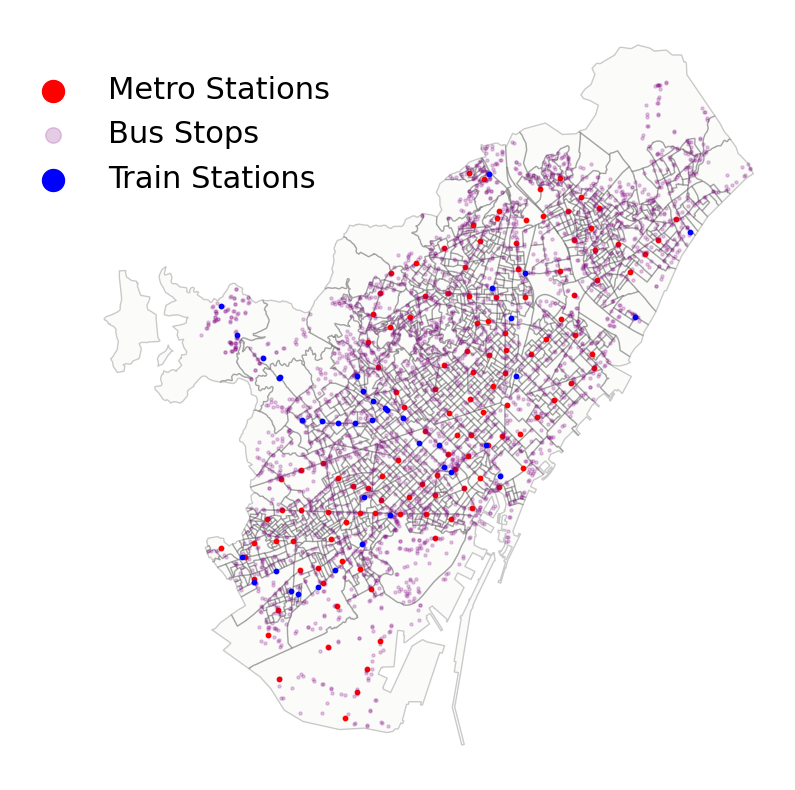

In [51]:
#Plot the stops and stations
fig, ax = plt.subplots(figsize=(10, 10))
cusecs.plot(ax=ax, color='#EDEBEA', edgecolor='black', alpha=0.2, label='Original Districts')
joined_metro[~joined_metro.CUSEC.isna()].plot(ax=ax, color='red', markersize=10, label='Metro Stations')
joined_bus[~joined_bus.CUSEC.isna()].plot(ax=ax, color='purple', markersize=5, alpha=0.2, label='Bus Stops')
joined_tren[~joined_tren.CUSEC.isna()].plot(ax=ax, color='blue', markersize=10, label='Train Stations')

ax.axis('off')

legend = ax.legend(prop={'size': 22}, bbox_to_anchor=(0.4, 0.95), markerscale=5 )
legend.set_frame_on(False)

plt.savefig('./figures/dots_transportation.png', dpi=300, bbox_inches='tight')

plt.show()

In [52]:
#### Select 10 random points in each CUSEC
#### Find distance to nearest point
#### Average the distances

'''
cusecs = cusecs.to_crs('EPSG:32631')

def generate_random_points(geometry):
    minx, miny, maxx, maxy = geometry.bounds
    points = []

    
    while len(points)<10:
        x = np.random.uniform(minx, maxx)
        y = np.random.uniform(miny, maxy)
        point = Point(x, y)
        if point.within(geometry):
            points.append(point)

    return points

cusecs['random_points'] = cusecs['geometry'].apply(generate_random_points)

import pickle
# Save GeoDataFrame to pickle file
with open('./data/geography/cusecs/comarca_with_random_points.pkl', 'wb') as f:
    pickle.dump(cusecs, f)

'''

"\ncusecs = cusecs.to_crs('EPSG:32631')\n\ndef generate_random_points(geometry):\n    minx, miny, maxx, maxy = geometry.bounds\n    points = []\n\n    \n    while len(points)<10:\n        x = np.random.uniform(minx, maxx)\n        y = np.random.uniform(miny, maxy)\n        point = Point(x, y)\n        if point.within(geometry):\n            points.append(point)\n\n    return points\n\ncusecs['random_points'] = cusecs['geometry'].apply(generate_random_points)\n\nimport pickle\n# Save GeoDataFrame to pickle file\nwith open('./data/geography/cusecs/comarca_with_random_points.pkl', 'wb') as f:\n    pickle.dump(cusecs, f)\n\n"

In [53]:
# We generated 10 points for each cusec, now load it
with open('./data/geography/cusecs/comarca_with_random_points.pkl', 'rb') as f:
    cusecs = pickle.load(f)

In [54]:
points_metro = points_metro.to_crs('EPSG:32631')
points_bus = points_bus.to_crs('EPSG:32631')
points_tren = points_tren.to_crs('EPSG:32631')

<Axes: >

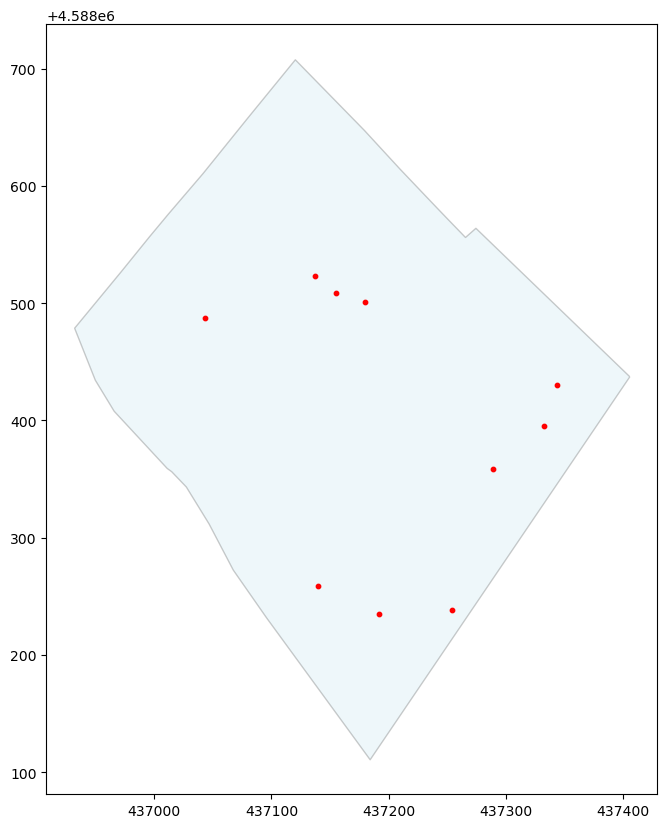

In [55]:
#Illustrate the 10 random points in one census tract
fig, ax = plt.subplots(figsize=(10, 10))
cusecs[cusecs.CUSEC =='0801501001'].plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.2, label='Original Districts')
random_points_geo = gpd.GeoSeries(cusecs['random_points'][0])
random_points_geo.plot(ax=ax, color='red', markersize=10, label='Random Points')

In [56]:
# Function to calculate distance to the closest point
def closest_distance_to_points_metro(point_list, points_df):
    point_coords = np.array([point.xy for point in point_list])
    points_metro_coords = np.array([point.xy for point in points_df['geometry']])

    all_distances = cdist(point_coords.reshape(-1, 2), points_metro_coords.reshape(-1, 2))
    #For each of the 10 points, find the shortest distance
    min_distances = [min(point) for point in all_distances]

    #Avg
    return np.mean(min_distances)

'''
# Apply the function
cusecs['neigh_closest_metro'] = cusecs['random_points'].apply(lambda x: closest_distance_to_points_metro(x, points_metro))
cusecs['neigh_closest_bus'] = cusecs['random_points'].apply(lambda x: closest_distance_to_points_metro(x, points_bus))
cusecs['neigh_closest_train'] = cusecs['random_points'].apply(lambda x: closest_distance_to_points_metro(x, points_tren))

with open('./data/geography/cusecs/comarca_with_random_points_distances.pkl', 'wb') as f:
    pickle.dump(cusecs, f)
    
'''

"\n# Apply the function\ncusecs['neigh_closest_metro'] = cusecs['random_points'].apply(lambda x: closest_distance_to_points_metro(x, points_metro))\ncusecs['neigh_closest_bus'] = cusecs['random_points'].apply(lambda x: closest_distance_to_points_metro(x, points_bus))\ncusecs['neigh_closest_train'] = cusecs['random_points'].apply(lambda x: closest_distance_to_points_metro(x, points_tren))\n\nwith open('./data/geography/cusecs/comarca_with_random_points_distances.pkl', 'wb') as f:\n    pickle.dump(cusecs, f)\n    \n"

In [57]:
# We got the mean distance to the closest stop
with open('./data/geography/cusecs/comarca_with_random_points_distances.pkl', 'rb') as f:
    cusecs = pickle.load(f)

In [58]:
cusecs=cusecs[['CUSEC','neigh_closest_metro','neigh_closest_bus','neigh_closest_train']].rename(columns={'CUSEC':'cusec'})

In [59]:
cusecs.cusec=cusecs.cusec.astype(int)

In [60]:
comarca=comarca.merge(cusecs, on='cusec',  how='left')

### 7. Schools

In [61]:
#escuelas=pd.read_excel('./data/escuelas/escuelas_direccion.xls')

In [62]:
#len(escuelas)
#1189

In [63]:
#Get list of full address
#escuelas['full_address']=escuelas['Adreça del centre']+', '+escuelas['Municipi del centre']+', '+'Spain'

In [64]:
#Use Google Mapsb
#import googlemaps
#API_KEY= some_key
#map_client= googlemaps.Client(API_KEY)

In [65]:
#resolution=[]

In [66]:
'''
for place in escuelas.full_address.tolist():
    try:
        response= map_client.geocode(place)
        lat=response[0]['geometry']['location']['lat']
        lon=response[0]['geometry']['location']['lng']
        location=[lat,lon]
        print(location)
        resolution.append(location)
    except:
        resolution.append([None, None])
        print('Not found')
'''

"\nfor place in escuelas.full_address.tolist():\n    try:\n        response= map_client.geocode(place)\n        lat=response[0]['geometry']['location']['lat']\n        lon=response[0]['geometry']['location']['lng']\n        location=[lat,lon]\n        print(location)\n        resolution.append(location)\n    except:\n        resolution.append([None, None])\n        print('Not found')\n"

In [67]:
#escuelas['lat_long']=resolution

In [68]:
#escuelas['lat']=escuelas.lat_long.apply(lambda x:x[0])
#escuelas['long']=escuelas.lat_long.apply(lambda x:x[1])

In [69]:
#escuelas.to_csv('./data/escuelas/escuelas_googlemaps.csv',index=False)

In [70]:
escuelas=pd.read_csv('./data/escuelas/escuelas_googlemaps.csv')

In [71]:
escuelas.tail(3)

Codi del centre                  Nom del centre     Adreça del centre  \
1186          8960261             ALT Fundació Comtal       Amadeu Vives, 6   
1187          8960303  ALT Fundació Privada Trinijove  c. Tucuman, 21 local   
1188          8960335                     ALT Femarec    c. Sardenya, 68-72   

      Codi municipi del centre Municipi del centre  \
1186                      8019           Barcelona   
1187                      8019           Barcelona   
1188                      8019           Barcelona   

     Districte municipal del centre  Codi postal del centre  \
1186                   Ciutat vella                    8003   
1187                    Sant Andreu                    8030   
1188                     Sant Martí                    8005   

      Telèfon del centre Telèfon 2 del centre  Codi naturalesa  ...  \
1186         933199855.0                  NaN              NaN  ...   
1187         933602403.0                  NaN              NaN  ...   
1188         934159417.0                  NaN              NaN  ...   

     Servei d'educació de Catalunya  Codi comarca del centre  \
1186                              N                       13   
1187                              N                       13   
1188                              N                       13   

     Comarca del centre Codi localitat del centre  \
1186         Barcelonès                    801901   
1187         Barcelonès                    801901   
1188         Barcelonès                    801901   

      Codi àrea territorial del centre       Àrea territorial del centre  \
1186                               108  Consorci d'Educació de Barcelona   
1187                               108  Consorci d'Educació de Barcelona   
1188                               108  Consorci d'Educació de Barcelona   

                                full_address                 lat_long  \
1186       Amadeu Vives, 6, Barcelona, Spain  [41.3879394, 2.1752618]   
1187  c. Tucuman, 21 local, Barcelona, Spain  [41.4465174, 2.2020005]   
1188    c. Sardenya, 68-72, Barcelona, Spain  [41.3916952, 2.1890076]   

            lat      long  
1186  41.387939  2.175262  
1187  41.446517  2.202001  
1188  41.391695  2.189008  

[3 rows x 23 columns]

Distance to closest school

In [72]:
#Read map
cusecs = gpd.read_file('./data/geography/cusecs/comarca_reduced.shp')

In [73]:
#Create coordinates
points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(escuelas['long'], escuelas['lat']))

In [74]:
#Project to same CRS
cusecs = cusecs.set_crs(epsg=4326)
points = points.set_crs(epsg=4326)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


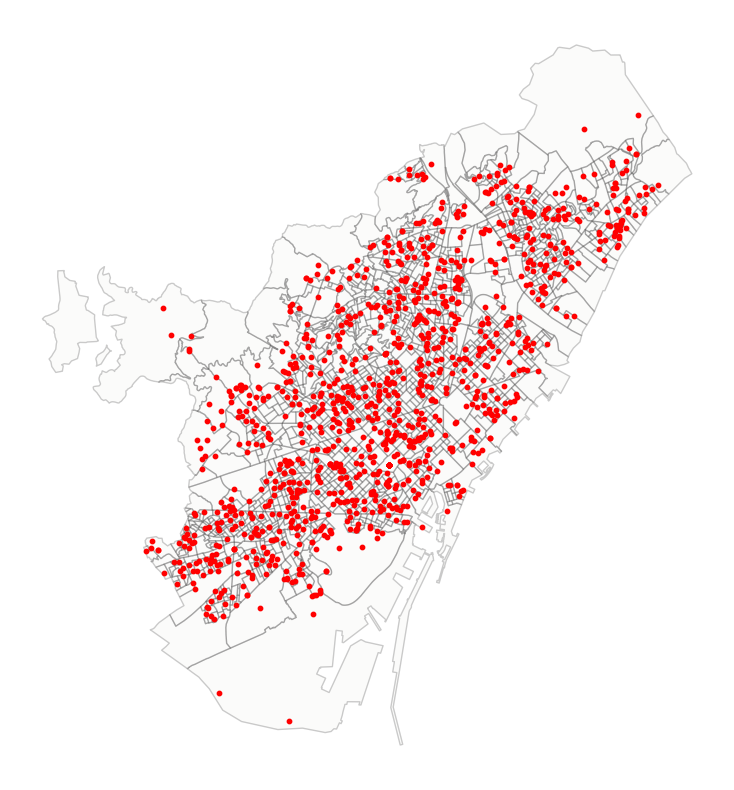

In [75]:
#Spatial joins

joined_school = gpd.sjoin(points, cusecs, how='left', op='within')

fig, ax = plt.subplots(figsize=(10, 10))
cusecs.plot(ax=ax, color='#EDEBEA', edgecolor='black', alpha=0.2, label='Original Districts')
joined_school[~joined_school.CUSEC.isna()].plot(ax=ax, color='red', markersize=10)

ax.axis('off')

legend = ax.legend(prop={'size': 18}, bbox_to_anchor=(0.4, 0.95), markerscale=5 )
legend.set_frame_on(False)

plt.savefig('./figures/dots_school.png', dpi=300, bbox_inches='tight')

plt.show()

In [76]:
points = points.to_crs('EPSG:32631')

In [77]:
# Function to calculate distance to the closest point
'''
def closest_distance_to_points_metro(point_list, points_df):
    point_coords = np.array([point.xy for point in point_list])
    points_metro_coords = np.array([point.xy for point in points_df['geometry']])

    all_distances = cdist(point_coords.reshape(-1, 2), points_metro_coords.reshape(-1, 2))
    #For each of the 10 points, find the shortest distance
    min_distances = [min(point) for point in all_distances]

    #Avg
    return np.mean(min_distances)


# Apply the function
cusecs['neigh_closest_school'] = cusecs['random_points'].apply(lambda x: closest_distance_to_points_metro(x, points))

with open('./data/geography/cusecs/comarca_with_random_points_distances.pkl', 'wb') as f:
    pickle.dump(cusecs, f)
'''

"\ndef closest_distance_to_points_metro(point_list, points_df):\n    point_coords = np.array([point.xy for point in point_list])\n    points_metro_coords = np.array([point.xy for point in points_df['geometry']])\n\n    all_distances = cdist(point_coords.reshape(-1, 2), points_metro_coords.reshape(-1, 2))\n    #For each of the 10 points, find the shortest distance\n    min_distances = [min(point) for point in all_distances]\n\n    #Avg\n    return np.mean(min_distances)\n\n\n# Apply the function\ncusecs['neigh_closest_school'] = cusecs['random_points'].apply(lambda x: closest_distance_to_points_metro(x, points))\n\nwith open('./data/geography/cusecs/comarca_with_random_points_distances.pkl', 'wb') as f:\n    pickle.dump(cusecs, f)\n"

In [78]:
# We got the mean distance to the closest stop
with open('./data/geography/cusecs/comarca_with_random_points_distances.pkl', 'rb') as f:
    cusecs = pickle.load(f)

In [79]:
cusecs=cusecs[['CUSEC','neigh_closest_school']].rename(columns={'CUSEC':'cusec'})

In [80]:
cusecs.cusec=cusecs.cusec.astype(int)

In [81]:
comarca=comarca.merge(cusecs, on='cusec',  how='left')

### 8. Places of Worship

In [82]:
#worship=pd.read_csv('./data/lugares_culto/lugares_culto.csv',sep=';', encoding='latin-1')

In [83]:
#This is the whole province
#len(worship)
#1102

In [84]:
#Get list of full address
#worship['full_address']=worship['Nombre de la vía']+', '+worship['Número']+', '+worship['Población']+', '+'Spain'

In [85]:
#Use Google Mapsb
#import googlemaps
#API_KEY= some_key
#map_client= googlemaps.Client(API_KEY)

In [86]:
#resolution=[]

In [87]:
'''
for place in worship.full_address.tolist():
    try:
        response= map_client.geocode(place)
        lat=response[0]['geometry']['location']['lat']
        lon=response[0]['geometry']['location']['lng']
        location=[lat,lon]
        print(location)
        resolution.append(location)
    except:
        resolution.append([None, None])
        print('Not found')
'''

"\nfor place in worship.full_address.tolist():\n    try:\n        response= map_client.geocode(place)\n        lat=response[0]['geometry']['location']['lat']\n        lon=response[0]['geometry']['location']['lng']\n        location=[lat,lon]\n        print(location)\n        resolution.append(location)\n    except:\n        resolution.append([None, None])\n        print('Not found')\n"

In [88]:
#worship['lat_long']=resolution

In [89]:
#worship['lat']=worship.lat_long.apply(lambda x:x[0])
#worship['long']=worship.lat_long.apply(lambda x:x[1])

In [90]:
#worship.to_csv('./data/lugares_culto/lugares_culto_googlemaps.csv',index=False)

In [91]:
worship=pd.read_csv('./data/lugares_culto/lugares_culto_googlemaps.csv')

In [92]:
worship.tail(3)

Nombre    Confesión  \
1099  World for Christ Bible Church (Iglesia Bíblica...  Evangélicos   
1100  Zen Kannon Comunitat Budista - Dojo Zen Barcelona     Budistas   
1101  Zona de Cataluña de la Iglesia Evangélica de F...  Evangélicos   

     Denominación                                         Página web  \
1099          NaN                                                NaN   
1100          NaN  https://zenkannon.org/; https://www.facebook.c...   
1101          NaN                                                NaN   

                  E-mail  Número de registro Número RER antiguo  \
1099                 NaN              3922.0           876-SG/A   
1100  info@zenkannon.org             14184.0          2065-SG/A   
1101                 NaN             21809.0          8620-SE/A   

                   Nombre de la vía Número    Resto  Código postal Distrito  \
1099    Carrer Sant Francesc Xavier     10    Local           8905      NaN   
1100  Gran Via de las Corts Catales    665     bajo           8010      NaN   
1101              Camí de Mas Martí     58  Tordera           8490      NaN   

                        Población  Provincia Comunidad autónoma  \
1099  Hospitalet de Llobregat, L'  Barcelona           Cataluña   
1100                    Barcelona  Barcelona           Cataluña   
1101                      Tordera  Barcelona           Cataluña   

      Tamaño del municipio                                       full_address  \
1099                264657  Carrer Sant Francesc Xavier, 10, Hospitalet de...   
1100               1636732  Gran Via de las Corts Catales, 665, Barcelona,...   
1101                 17788              Camí de Mas Martí, 58, Tordera, Spain   

                            lat_long        lat      long  
1099         [41.3672596, 2.1081982]  41.367260  2.108198  
1100  [41.39407730000001, 2.1737698]  41.394077  2.173770  
1101         [41.6952107, 2.7154564]  41.695211  2.715456

In [93]:
#Read map
cusecs = gpd.read_file('./data/geography/cusecs/comarca_reduced.shp')

In [94]:
cristianos = [
    "Evangélicos",
    "Testigos de Jehová",
    "Adventistas",
    "Iglesia de Jesucristo de los Santos de los Últimos Días",
    "Comunión Anglicana",
    "Otras Conf. Cristianas",
    "Ciencia cristiana"
]
worship_chr=worship[worship.Confesión.isin(cristianos)]
worship_mus=worship[worship.Confesión.isin(['Musulmanes'])]
worship_bud=worship[worship.Confesión.isin(['Budistas'])]
worship_ort=worship[worship.Confesión.isin(['Ortodoxos'])]

In [95]:
#Create coordinates
points_chr = gpd.GeoDataFrame(geometry=gpd.points_from_xy(worship_chr['long'], worship_chr['lat'])).set_crs(epsg=4326)
points_mus = gpd.GeoDataFrame(geometry=gpd.points_from_xy(worship_mus['long'], worship_mus['lat'])).set_crs(epsg=4326)
points_bud = gpd.GeoDataFrame(geometry=gpd.points_from_xy(worship_bud['long'], worship_bud['lat'])).set_crs(epsg=4326)
points_ort = gpd.GeoDataFrame(geometry=gpd.points_from_xy(worship_ort['long'], worship_ort['lat'])).set_crs(epsg=4326)

In [96]:
# Set CRS that is aligned with meters scale
cusecs = cusecs.set_crs(epsg=4326)
cusecs_buffered = cusecs.to_crs("EPSG:32634")
cusecs_buffered.geometry = cusecs_buffered.geometry.buffer(300, 6)

In [97]:
cusecs_buffered = cusecs_buffered.to_crs("EPSG:4326")

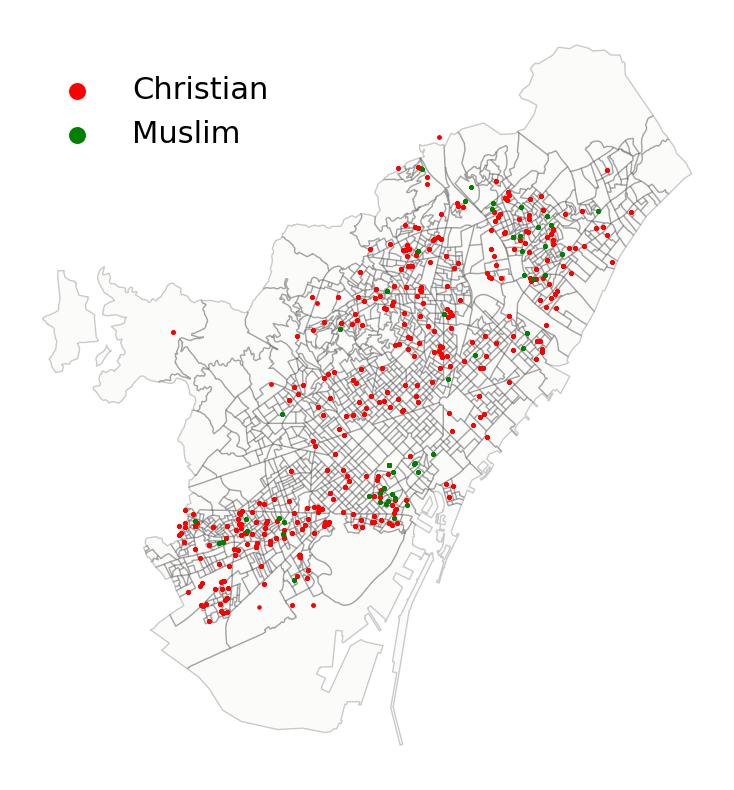

In [98]:
fig, ax = plt.subplots(figsize=(10, 10))
cusecs.plot(ax=ax, color='#EDEBEA', edgecolor='black', alpha=0.2, label='Original Districts')
#Plot Christian
joined = gpd.sjoin(points_chr, cusecs_buffered, how='left', op='within')
joined[~joined.CUSEC.isna()].plot(ax=ax, color='red', markersize=5, label='Christian')
#Plot Muslim
joined = gpd.sjoin(points_mus, cusecs_buffered, how='left', op='within')
joined[~joined.CUSEC.isna()].plot(ax=ax, color='green', markersize=5, label='Muslim')
ax.axis('off')

legend = ax.legend(prop={'size': 22}, bbox_to_anchor=(0.4, 0.95) , markerscale=5)
legend.set_frame_on(False)

plt.savefig('./figures/dots_religious.png', dpi=300, bbox_inches='tight')

plt.show()

In [99]:
# We generated 10 points for each cusec, now load it
with open('./data/geography/cusecs/comarca_with_random_points.pkl', 'rb') as f:
    cusecs = pickle.load(f)

In [100]:
points_chr = points_chr.to_crs('EPSG:32631')
points_mus = points_mus.to_crs('EPSG:32631')
points_bud = points_bud.to_crs('EPSG:32631')
points_ort = points_ort.to_crs('EPSG:32631')

In [101]:
points_chr=points_chr[~points_chr.is_empty]
points_mus=points_mus[~points_mus.is_empty]
points_bud=points_bud[~points_bud.is_empty]
points_ort=points_ort[~points_ort.is_empty]

In [102]:
# Function to calculate distance to the closest point
def closest_distance_to_points_metro(point_list, points_df):
    point_coords = np.array([point.xy for point in point_list])
    points_metro_coords = np.array([point.xy for point in points_df['geometry']])

    all_distances = cdist(point_coords.reshape(-1, 2), points_metro_coords.reshape(-1, 2))
    #For each of the 10 points, find the shortest distance
    min_distances = [min(point) for point in all_distances]

    #Avg
    return np.mean(min_distances)

In [103]:
# Apply the function
cusecs['neigh_closest_worsh_christ'] = cusecs['random_points'].apply(lambda x: closest_distance_to_points_metro(x, points_chr))
cusecs['neigh_closest_worsh_bud'] = cusecs['random_points'].apply(lambda x: closest_distance_to_points_metro(x, points_bud))
cusecs['neigh_closest_worsh_ort'] = cusecs['random_points'].apply(lambda x: closest_distance_to_points_metro(x, points_ort))
cusecs['neigh_closest_worsh_mus'] = cusecs['random_points'].apply(lambda x: closest_distance_to_points_metro(x, points_mus))

In [104]:
cusecs=cusecs.rename(columns={'CUSEC':'cusec'})

In [105]:
cusecs.cusec=cusecs.cusec.astype(int)

In [106]:
comarca=comarca.merge(cusecs[['cusec','neigh_closest_worsh_christ', 'neigh_closest_worsh_bud', 'neigh_closest_worsh_ort', 'neigh_closest_worsh_mus']],
                      on='cusec',how='left')

### 9. Driving Distance to Center

In [107]:
'''

#Use Google Mapsb
API_KEY= some_key
map_client= googlemaps.Client(API_KEY)

# We generated 10 points for each cusec, now load it
with open('./data/geography/cusecs/comarca_with_random_points.pkl', 'rb') as f:
    cusecs = pickle.load(f)
    

# Define a function to reproject a single point
def reproject_point(point, from_crs, to_crs):
    project = partial(pyproj.transform, pyproj.Proj(init=from_crs), pyproj.Proj(init=to_crs))
    return transform(project, point)

# Reproject the 'random_points' column to EPSG:4326
from_crs = 'EPSG:32631'  # replace with the actual CRS of your 'random_points' column
to_crs = 'EPSG:4326'
cusecs['random_points'] = cusecs['random_points'].apply(lambda points: [reproject_point(Point(point), from_crs, to_crs) for point in points])

#Use Google Maps Directions to get dirances and driving time
result=[]
for i,row in cusecs.iterrows():
        points=row.random_points
        points=random.sample(points, 5)
        row_results=[]
        for pip in points:
            ran_point=[pip.y,pip.x]
            print(ran_point)
            try:
                response= map_client.directions(
                    origin=ran_point,
                    destination=[41.387049750981326, 2.170051799215122],
                    mode='driving',
                    )
                dist_m=response[0]['legs'][0]['distance']['value']
                dur_sec=response[0]['legs'][0]['duration']['value']
                driving=[dist_m,dur_sec]
                print(driving)
                row_results.append(driving)
            except:
                row_results.append([None, None])
        result.append(row_results)
        
cusecs['driving']=result
with open('./data/geography/cusecs/comarca_with_driving_distances.pkl', 'wb') as f:
    pickle.dump(cusecs, f)
    
'''

"\n\n#Use Google Mapsb\nAPI_KEY= some_key\nmap_client= googlemaps.Client(API_KEY)\n\n# We generated 10 points for each cusec, now load it\nwith open('./data/geography/cusecs/comarca_with_random_points.pkl', 'rb') as f:\n    cusecs = pickle.load(f)\n    \n\n# Define a function to reproject a single point\ndef reproject_point(point, from_crs, to_crs):\n    project = partial(pyproj.transform, pyproj.Proj(init=from_crs), pyproj.Proj(init=to_crs))\n    return transform(project, point)\n\n# Reproject the 'random_points' column to EPSG:4326\nfrom_crs = 'EPSG:32631'  # replace with the actual CRS of your 'random_points' column\nto_crs = 'EPSG:4326'\ncusecs['random_points'] = cusecs['random_points'].apply(lambda points: [reproject_point(Point(point), from_crs, to_crs) for point in points])\n\n#Use Google Maps Directions to get dirances and driving time\nresult=[]\nfor i,row in cusecs.iterrows():\n        points=row.random_points\n        points=random.sample(points, 5)\n        row_results=[]\n

In [108]:
with open('./data/geography/cusecs/comarca_with_driving_distances.pkl', 'rb') as f:
    cusecs = pickle.load(f)

In [109]:
cusecs.head(3)

CUSEC  CUMUN CSEC CDIS CMUN CPRO CCA    CUDIS  CLAU2       NPRO  \
0  0801501001  08015  001   01  015   08  09  0801501  08015  Barcelona   
1  0801501002  08015  002   01  015   08  09  0801501  08015  Barcelona   
2  0801501003  08015  003   01  015   08  09  0801501  08015  Barcelona   

        NCA CNUT0 CNUT1 CNUT2 CNUT3      NMUN  \
0  Cataluña    ES     5     1     1  Badalona   
1  Cataluña    ES     5     1     1  Badalona   
2  Cataluña    ES     5     1     1  Badalona   

                                            geometry  \
0  POLYGON ((437405.144 4588437.633, 437183.730 4...   
1  POLYGON ((437478.522 4588545.850, 437405.144 4...   
2  POLYGON ((437360.533 4588936.337, 437362.883 4...   

                                       random_points  \
0  [POINT (2.249791856741791 41.44468760164871), ...   
1  [POINT (2.2492447248602034 41.44635718305105),...   
2  [POINT (2.250935255731694 41.447035984122465),...   

                                             driving  
0  [[12315, 1646], [11673, 1525], [11811, 1518], ...  
1  [[13531, 1751], [11907, 1645], [11873, 1656], ...  
2  [[12013, 1682], [13593, 1782], [13308, 1718], ...

In [110]:
cusecs['neigh_center_dist_m'] = cusecs['driving'].apply(lambda x: sum(i[0] for i in x) / len(x))
cusecs['neigh_center_dist_sec'] = cusecs['driving'].apply(lambda x: sum(i[1] for i in x) / len(x))

In [111]:
cusecs.CUSEC=cusecs.CUSEC.astype(int)

In [112]:
comarca=comarca.merge(cusecs[['CUSEC','neigh_center_dist_m','neigh_center_dist_sec']].rename(columns={'CUSEC':'cusec'}),how='left',on='cusec')

### 10. Catastral Data

In [113]:
#District level catastral data
cat = pd.read_csv('./data/catastro/catastro_distritos.csv',skiprows=5,encoding='latin-1')

In [114]:
cat['district'] = cat['Unnamed: 0'].str.split('-').str[0]

In [115]:
#Those ending in 99 are not specified
cat=cat[~cat['Unnamed: 0'].isin(['0801999 - Barcelona','0801599 - Badalona'])]

In [116]:
cat=cat[['district','Aparcamiento','Comercial','Industrial','Oficinas']]
cat.columns=['district','neigh_parking_per_area','neigh_commerc_per_area','neigh_indust_per_area','neigh_office_per_area']

In [117]:
cat=cat.iloc[:-4,:]
cat.district=cat.district.astype(int)

In [118]:
cat=cat.replace({'..':0})

In [119]:
cat[['neigh_parking_per_area', 'neigh_commerc_per_area',
       'neigh_indust_per_area', 'neigh_office_per_area']]= cat[['neigh_parking_per_area', 'neigh_commerc_per_area',
       'neigh_indust_per_area', 'neigh_office_per_area']].astype(str).replace('\.', '', regex=True).astype(int)

In [120]:
cat

district  neigh_parking_per_area  neigh_commerc_per_area  \
0       80011                      30                     157   
1       80021                      47                       0   
2       80031                      26                      93   
3       80041                      37                       0   
4       80051                      29                     365   
..        ...                     ...                     ...   
587     89011                      53                      66   
588     89021                      30                     146   
589     89031                     104                       0   
590     89041                      31                     132   
591     89051                      31                     113   

     neigh_indust_per_area  neigh_office_per_area  
0                     3341                   2476  
1                      516                      0  
2                      287                    709  
3                      282                      0  
4                      771                    346  
..                     ...                    ...  
587                    384                      0  
588                    866                    701  
589                     72                      0  
590                   1673                   2742  
591                    486                    347  

[590 rows x 5 columns]

Make these numbers per km2

In [121]:
comarca['district']=(comarca['CUMUN'].astype(str) + comarca['CDIS'].astype(str)).astype(int)

In [122]:
#Find total area in district
district_areas=comarca[['district','area']].drop_duplicates().groupby('district').area.sum().reset_index()

#Make it square kilomenter
district_areas['area']=district_areas  ['area']/1000000

In [123]:
cat=cat.merge(district_areas, on='district', how='left' )
cat=cat[~cat.area.isna()]

In [124]:
cat[['neigh_parking_per_area','neigh_commerc_per_area','neigh_indust_per_area','neigh_office_per_area']]=cat[['neigh_parking_per_area','neigh_commerc_per_area','neigh_indust_per_area','neigh_office_per_area']].astype(float)

In [125]:
cat[['neigh_parking_per_area','neigh_commerc_per_area','neigh_indust_per_area','neigh_office_per_area']]=cat[['neigh_parking_per_area','neigh_commerc_per_area','neigh_indust_per_area','neigh_office_per_area']].div(cat.area, axis=0)
cat.head(5)

district  neigh_parking_per_area  neigh_commerc_per_area  \
23     80151               69.331991              286.450594   
24     80152               46.812445              189.924778   
25     80153               35.642319              124.238940   
26     80154               16.262156              119.080952   
27     80155               22.753741              122.764371   

    neigh_indust_per_area  neigh_office_per_area      area  
23             492.622040             291.924172  0.548088  
24             801.161564             199.287267  0.747664  
25             324.854279             131.367404  0.981979  
26             403.930981             135.343108  1.906266  
27             357.180820             176.738361  1.889799

In [126]:
comarca=comarca.merge(cat.drop('area',axis=1), on='district', how='left')

### 11. Total Area

In [127]:
comarca['neigh_area']=comarca.area/1000000

## Final touches

In [128]:
comarca=comarca.drop(['year','CUSEC','CMUN','CSEC','CDIS','CMUN','CUMUN','CPRO','CCA','CUDIS','CLAU2','NPRO','NCA', 'CNUT0',
       'CNUT1', 'CNUT2', 'CNUT3', 'NMUN', 'area'],axis=1)

In [129]:
cusec_level_data=comarca[['cusec', 'cob','population','census_total_pop',
                          
        ##Demographic variables
       'demog_avg_income',  'demog_mean_age','demog_hh_5p+',
        ## Housing variables
       'housing_rented', 'housing_constr_bef_1940',
       'housing_constr_aft_2000', 'housing_floor_1', 'housing_floor_7_plus',
       'housing_m2_und_60', 'housing_m2_ovr_120',
       'housing_rent_m2_median',  
        ## Neighborhood variables
      'neigh_closest_school',                
      'neigh_closest_metro', 'neigh_closest_bus','neigh_closest_train', 
        'neigh_closest_worsh_christ','neigh_closest_worsh_mus', 
        'neigh_center_dist_m',
       'neigh_commerc_per_area', 'neigh_indust_per_area',
       'neigh_office_per_area',
        'neigh_area'        ]].drop_duplicates()

In [130]:
#No missing values
cusec_level_data.isna().sum()

cusec                         0
cob                           0
population                    0
census_total_pop              0
demog_avg_income              0
demog_mean_age                0
demog_hh_5p+                  0
housing_rented                0
housing_constr_bef_1940       0
housing_constr_aft_2000       0
housing_floor_1               0
housing_floor_7_plus          0
housing_m2_und_60             0
housing_m2_ovr_120            0
housing_rent_m2_median        0
neigh_closest_school          0
neigh_closest_metro           0
neigh_closest_bus             0
neigh_closest_train           0
neigh_closest_worsh_christ    0
neigh_closest_worsh_mus       0
neigh_center_dist_m           0
neigh_commerc_per_area        0
neigh_indust_per_area         0
neigh_office_per_area         0
neigh_area                    0
dtype: int64

### Correlations and Descriptives

In [131]:
bcn=cusec_level_data.copy()

In [132]:
#Make 1 row per cuses
bcn=bcn.drop(['cob','population'],axis=1).drop_duplicates().reset_index(drop=True)

Correlation matrix pre-feature selections

In [133]:
z = round(comarca.drop(['cob','population'],axis=1).drop_duplicates().corr(), 2)
fig = px.imshow(z, text_auto=True, aspect="auto", height=1000) # Set the height as required
fig.show()

Correlation matrix post selection

In [134]:
import plotly.express as px

z = round(bcn[[    ##Demographic variables
       'demog_avg_income',  'demog_mean_age','demog_hh_5p+',
        ## Housing variables
       'housing_rented', 'housing_constr_bef_1940',
       'housing_constr_aft_2000', 'housing_floor_1', 'housing_floor_7_plus',
       'housing_m2_und_60', 'housing_m2_ovr_120',
       'housing_rent_m2_median',  
        ## Neighborhood variables
      'neigh_closest_school',                
      'neigh_closest_metro', 'neigh_closest_bus','neigh_closest_train', 
        'neigh_closest_worsh_christ','neigh_closest_worsh_mus', 
        'neigh_center_dist_m', 'neigh_indust_per_area',
       'neigh_office_per_area',
        'neigh_area','census_total_pop'   
       ]].corr(), 2)

fig = px.imshow(z, text_auto=True, aspect="auto", height=500) # Set the height as required
fig.update_layout(xaxis=dict(tickfont=dict(size=10)), yaxis=dict(tickfont=dict(size=10)))

fig.write_image("./figures/correlation_indep.png", scale=2)

fig.show()


In [135]:
#Make the percentages real percentages
bcn[['demog_hh_5p+',  'housing_rented', 'housing_constr_bef_1940', 'housing_constr_aft_2000',
       'housing_floor_1', 'housing_floor_7_plus', 'housing_m2_und_60','housing_m2_ovr_120']]=bcn[['demog_hh_5p+',  'housing_rented', 'housing_constr_bef_1940', 'housing_constr_aft_2000',
       'housing_floor_1', 'housing_floor_7_plus', 'housing_m2_und_60','housing_m2_ovr_120']]*100

In [136]:
bcn.drop('cusec',axis=1).describe().T

count          mean          std          min  \
census_total_pop            1520.0   1500.636184   446.971029   448.000000   
demog_avg_income            1520.0  15939.801316  4814.012185  5584.000000   
demog_mean_age              1520.0     44.511311     2.991355    32.976200   
demog_hh_5p+                1520.0      6.948758     3.396704     1.602564   
housing_rented              1520.0     24.212994     7.502840     3.025937   
housing_constr_bef_1940     1520.0     16.124610    22.901400     0.000000   
housing_constr_aft_2000     1520.0      6.735511    12.416177     0.000000   
housing_floor_1             1520.0      2.875647     6.499078     0.000000   
housing_floor_7_plus        1520.0     37.542263    33.407996     0.000000   
housing_m2_und_60           1520.0     52.048545    24.586666     0.000000   
housing_m2_ovr_120          1520.0      4.393445    10.374337     0.000000   
housing_rent_m2_median      1520.0     11.474003     1.826252     6.034483   
neigh_closest_school        1520.0    142.722552    95.202615    33.749525   
neigh_closest_metro         1520.0    399.141751   322.439497    50.446841   
neigh_closest_bus           1520.0     96.892625    53.025577    29.454916   
neigh_closest_train         1520.0   1042.512918   609.519942    71.137719   
neigh_closest_worsh_christ  1520.0    273.423355   230.217715    32.381667   
neigh_closest_worsh_mus     1520.0    782.454297   497.182035    54.909597   
neigh_center_dist_m         1520.0   6601.821842  3316.124737   602.200000   
neigh_commerc_per_area      1520.0     52.595141    73.738755     7.360283   
neigh_indust_per_area       1520.0    227.081706   345.366709    46.064353   
neigh_office_per_area       1520.0    110.273418   107.926472    14.320005   
neigh_area                  1520.0      0.096354     0.514768     0.008860   

                                     25%           50%           75%  \
census_total_pop             1227.000000   1452.000000   1696.250000   
demog_avg_income            12482.250000  15599.500000  18319.000000   
demog_mean_age                 42.839350     44.757750     46.419925   
demog_hh_5p+                    4.775910      5.899928      8.025026   
housing_rented                 18.776936     24.448192     29.246975   
housing_constr_bef_1940         0.000000      4.607692     23.997119   
housing_constr_aft_2000         0.000000      2.521632      7.201310   
housing_floor_1                 0.224468      0.875914      2.697854   
housing_floor_7_plus            5.025744     30.774307     65.373773   
housing_m2_und_60              34.145285     52.999849     69.668809   
housing_m2_ovr_120              0.149986      0.868622      3.022277   
housing_rent_m2_median         10.286007     11.573111     12.581210   
neigh_closest_school           87.997147    123.280154    170.203929   
neigh_closest_metro           232.964616    324.482893    442.688825   
neigh_closest_bus              67.629303     86.314268    112.557683   
neigh_closest_train           546.438415    948.753720   1448.185981   
neigh_closest_worsh_christ    133.401651    213.771754    329.958451   
neigh_closest_worsh_mus       380.437167    695.192041   1120.134463   
neigh_center_dist_m          3999.550000   5942.100000   8995.850000   
neigh_commerc_per_area         15.409503     28.870606     40.916301   
neigh_indust_per_area          80.401325    136.312263    252.434890   
neigh_office_per_area          39.697083     68.429178    118.511675   
neigh_area                      0.024142      0.035633      0.056770   

                                     max  
census_total_pop             8269.000000  
demog_avg_income            32039.000000  
demog_mean_age                 55.189800  
demog_hh_5p+                   28.130360  
housing_rented                 64.481707  
housing_constr_bef_1940        99.868421  
housing_constr_aft_2000       100.000000  
housing_floor_1                92.086331  
housing_floor_7_plus          100.000000

Let's drop Commercial per area, as it's strongly correlated with Office per area

In [241]:
cusec_level_data=cusec_level_data.drop('neigh_commerc_per_area',axis=1)

## Adding Indeces

In [243]:
cusec_level_data=cusec_level_data.sort_values(['cusec','cob'],ascending=True)

In [244]:
cusec_level_data

cusec              cob  population  census_total_pop  \
0      801501001         Alemania           3              1496   
7      801501001        Argentina          11              1496   
8      801501001          Bolivia           1              1496   
9      801501001           Brasil           2              1496   
12     801501001            Chile           1              1496   
...          ...              ...         ...               ...   
30044  824506014      Reino Unido           0              2599   
30056  824506014  Rep. Dominicana          78              2599   
30043  824506014          Rumanía          10              2599   
30045  824506014            Rusia           0              2599   
30057  824506014        Venezuela           7              2599   

       demog_avg_income  demog_mean_age  demog_hh_5p+  housing_rented  \
0               20947.0         45.2134      0.044369        0.200288   
7               20947.0         45.2134      0.044369        0.200288   
8               20947.0         45.2134      0.044369        0.200288   
9               20947.0         45.2134      0.044369        0.200288   
12              20947.0         45.2134      0.044369        0.200288   
...                 ...             ...           ...             ...   
30044            8109.0         37.3168      0.175060        0.337169   
30056            8109.0         37.3168      0.175060        0.337169   
30043            8109.0         37.3168      0.175060        0.337169   
30045            8109.0         37.3168      0.175060        0.337169   
30057            8109.0         37.3168      0.175060        0.337169   

       housing_constr_bef_1940  housing_constr_aft_2000  ...  \
0                     0.265086                 0.217672  ...   
7                     0.265086                 0.217672  ...   
8                     0.265086                 0.217672  ...   
9                     0.265086                 0.217672  ...   
12                    0.265086                 0.217672  ...   
...                        ...                      ...  ...   
30044                 0.005172                 0.034483  ...   
30056                 0.005172                 0.034483  ...   
30043                 0.005172                 0.034483  ...   
30045                 0.005172                 0.034483  ...   
30057                 0.005172                 0.034483  ...   

       neigh_closest_school  neigh_closest_metro  neigh_closest_bus  \
0                209.279212           605.572607          96.448505   
7                209.279212           605.572607          96.448505   
8                209.279212           605.572607          96.448505   
9                209.279212           605.572607          96.448505   
12               209.279212           605.572607          96.448505   
...                     ...                  ...                ...   
30044            212.302968           213.839195          55.660285   
30056            212.302968           213.839195          55.660285   
30043            212.302968           213.839195          55.660285   
30045            212.302968           213.839195          55.660285   
30057            212.302968           213.839195          55.660285   

       neigh_closest_train  neigh_closest_worsh_christ  \
0                183.98168                  567.496927   
7                183.98168                  567.496927   
8                183.98168                  567.496927   
9                183.98168                  567.496927   
12               183.98168                  567.496927   
...                    ...                         ...   
30044           2452.33745                  241.645449   
30056           2452.33745                  241.645449   
30043           2452.33745                  241.645449   
30045           2452.33745                  241.645449   
30057           2452.33745                  241.645449   

       nei

In [248]:
#Assign index to cusec
text_to_index = {text: index +1 for index, text in enumerate(cusec_level_data['cusec'].unique())}
cusec_level_data['cusec_idx'] = cusec_level_data['cusec'].map(text_to_index)

In [250]:
#Assign index to cob
text_to_index = {text: index +1 for index, text in enumerate(cusec_level_data['cob'].unique())}
cusec_level_data['cob_idx'] = cusec_level_data['cob'].map(text_to_index)

In [253]:
cusec_level_data=cusec_level_data[['cusec', 'cusec_idx', 'cob',  'cob_idx', 'population', 'census_total_pop', 'demog_avg_income',
       'demog_mean_age', 'demog_hh_5p+', 'housing_rented',
       'housing_constr_bef_1940', 'housing_constr_aft_2000', 'housing_floor_1',
       'housing_floor_7_plus', 'housing_m2_und_60', 'housing_m2_ovr_120',
       'housing_rent_m2_median', 'neigh_closest_school', 'neigh_closest_metro',
       'neigh_closest_bus', 'neigh_closest_train',
       'neigh_closest_worsh_christ', 'neigh_closest_worsh_mus',
       'neigh_center_dist_m', 'neigh_indust_per_area', 'neigh_office_per_area',
       'neigh_area']]

In [255]:
cusec_level_data[['cusec', 'cusec_idx']].drop_duplicates()

cusec  cusec_idx
0      801501001          1
20     801501002          2
40     801501003          3
60     801501004          4
80     801501005          5
...          ...        ...
29960  824506008       1516
29980  824506009       1517
30000  824506011       1518
30020  824506012       1519
30040  824506014       1520

[1520 rows x 2 columns]

In [256]:
cusec_level_data[['cob',  'cob_idx']].drop_duplicates()

cob  cob_idx
0          Alemania        1
7         Argentina        2
8           Bolivia        3
9            Brasil        4
12            Chile        5
18            China        6
10         Colombia        7
11             Cuba        8
13          Ecuador        9
1           Francia       10
2            Italia       11
6         Marruecos       12
19         Pakistán       13
14         Paraguay       14
15             Perú       15
4       Reino Unido       16
16  Rep. Dominicana       17
3           Rumanía       18
5             Rusia       19
17        Venezuela       20

## Final Export

In [257]:
cusec_level_data.to_csv('./intermediate_files/feature_matrix_final.csv',index=False)

## Adjacency Matrix

Example:
    
How the original data should look like before mungeCARdata4stan:
    
https://github.com/stan-dev/example-models/blob/master/knitr/car-iar-poisson/scotland_data.R


adjBUGS	= adj
A vector of neighbor indices

numBUGS	= num
A vector containing the number of neighbors for each point.

Value
Returns a list where J is the number predictors, J_edges is the number of edges in connected graph representing the spatial data, and node1, node2 are required to fit the model without explicitly specifying an adjacency matrix

In [143]:
#Read map
gdf = gpd.read_file('./data/geography/cusecs/comarca_reduced.shp')

In [144]:
#Remove the ones that had no data in 2021
gdf = gdf[~gdf.CUSEC.isin(['0801503015', '0801505008'])]

In [145]:
gdf=gdf.sort_values('CUSEC',ascending=True)
gdf=gdf.reset_index(drop=True)

In [146]:
sindex = gdf.sindex

In [147]:
sindex

In [148]:
gdf

CUSEC  CUMUN CSEC CDIS CMUN CPRO CCA    CUDIS  CLAU2       NPRO  \
0     0801501001  08015  001   01  015   08  09  0801501  08015  Barcelona   
1     0801501002  08015  002   01  015   08  09  0801501  08015  Barcelona   
2     0801501003  08015  003   01  015   08  09  0801501  08015  Barcelona   
3     0801501004  08015  004   01  015   08  09  0801501  08015  Barcelona   
4     0801501005  08015  005   01  015   08  09  0801501  08015  Barcelona   
...          ...    ...  ...  ...  ...  ...  ..      ...    ...        ...   
1515  0824506008  08245  008   06  245   08  09  0824506  08245  Barcelona   
1516  0824506009  08245  009   06  245   08  09  0824506  08245  Barcelona   
1517  0824506011  08245  011   06  245   08  09  0824506  08245  Barcelona   
1518  0824506012  08245  012   06  245   08  09  0824506  08245  Barcelona   
1519  0824506014  08245  014   06  245   08  09  0824506  08245  Barcelona   

           NCA CNUT0 CNUT1 CNUT2 CNUT3                      NMUN  \
0     Cataluña    ES     5     1     1                  Badalona   
1     Cataluña    ES     5     1     1                  Badalona   
2     Cataluña    ES     5     1     1                  Badalona   
3     Cataluña    ES     5     1     1                  Badalona   
4     Cataluña    ES     5     1     1                  Badalona   
...        ...   ...   ...   ...   ...                       ...   
1515  Cataluña    ES     5     1     1  Santa Coloma de Gramenet   
1516  Cataluña    ES     5     1     1  Santa Coloma de Gramenet   
1517  Cataluña    ES     5     1     1  Santa Coloma de Gramenet   
1518  Cataluña    ES     5     1     1  Santa Coloma de Gramenet   
1519  Cataluña    ES     5     1     1  Santa Coloma de Gramenet   

                                               geometry  
0     POLYGON ((2.25066 41.44508, 2.24805 41.44212, ...  
1     POLYGON ((2.25153 41.44606, 2.25066 41.44508, ...  
2     POLYGON ((2.25008 41.44956, 2.25010 41.44954, ...  
3     POLYGON ((2.25477 41.44972, 2.25401 41.44887, ...  
4     POLYGON ((2.24722 41.44749, 2.24674 41.44704, ...  
...                                                 ...  
1515  POLYGON ((2.21659 41.45099, 2.21704 41.45013, ...  
1516  POLYGON ((2.22094 41.44967, 2.22093 41.44966, ...  
1517  POLYGON ((2.22168 41.44801, 2.22160 41.44791, ...  
1518  POLYGON ((2.21935 41.44994, 2.21953 41.44966, ...  
1519  POLYGON ((2.21803 41.44855, 2.21832 41.44812, ...  

[1520 rows x 17 columns]

In [149]:
# Initialize the adjacency matrix
n = len(gdf)
adjacency_matrix = np.zeros((n, n), dtype=int)

# Loop through each polygon
for i in range(n):
    # Find the neighbors of the current polygon
    neighbors = list(sindex.intersection(gdf.geometry[i].bounds))
    # Remove the current polygon from the list of neighbors
    neighbors.remove(i)
    # Update the adjacency matrix
    for neighbor in neighbors:
        adjacency_matrix[i][neighbor] = 1

# Print or use the adjacency matrix as needed
print(adjacency_matrix)

[[0 1 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 1 1 0]]


In [150]:
adjacency_matrix=pd.DataFrame(adjacency_matrix,columns=gdf.CUSEC, index=gdf.CUSEC)
adjacency_matrix

CUSEC       0801501001  0801501002  0801501003  0801501004  0801501005  \
CUSEC                                                                    
0801501001           0           1           1           0           1   
0801501002           1           0           1           1           1   
0801501003           1           1           0           1           0   
0801501004           0           1           1           0           0   
0801501005           1           1           0           0           0   
...                ...         ...         ...         ...         ...   
0824506008           0           0           0           0           0   
0824506009           0           0           0           0           0   
0824506011           0           0           0           0           0   
0824506012           0           0           0           0           0   
0824506014           0           0           0           0           0   

CUSEC       0801501007  0801502001  0801502002  0801502003  0801502004  ...  \
CUSEC                                                                   ...   
0801501001           0           0           0           0           0  ...   
0801501002           1           0           1           1           0  ...   
0801501003           1           0           0           1           0  ...   
0801501004           1           0           0           0           1  ...   
0801501005           0           1           1           0           0  ...   
...                ...         ...         ...         ...         ...  ...   
0824506008           0           0           0           0           0  ...   
0824506009           0           0           0           0           0  ...   
0824506011           0           0           0           0           0  ...   
0824506012           0           0           0           0           0  ...   
0824506014           0           0           0           0           0  ...   

CUSEC       0824505019  0824506002  0824506003  0824506004  0824506005  \
CUSEC                                                                    
0801501001           0           0           0           0           0   
0801501002           0           0           0           0           0   
0801501003           0           0           0           0           0   
0801501004           0           0           0           0           0   
0801501005           0           0           0           0           0   
...                ...         ...         ...         ...         ...   
0824506008           0           1           1           0           0   
0824506009           0           0           0           0           1   
0824506011           0           0           1           0           1   
0824506012           0           0           1           0           1   
0824506014           0           0           0           0           0   

CUSEC       0824506008  0824506009  0824506011  0824506012  0824506014  
CUSEC                                                                   
0801501001           0           0           0           0           0  
0801501002           0           0           0           0           0  
0801501003           0           0           0           0           0  
0801501004           0           0           0           0           0  
0801501005           0           0           0           0           0  
...                ...         ...         ...         ...         ...  
0824506008           0           0           0           1           1  
0824506009           0           0           1           1           0  
0824506011           0           1           0           1           1  
0824506012           1           1           1           0           1  
0824506014           1           0           1           1           0  

[1520 rows x 1520 columns]

In [151]:
#Assign index to cusec
text_to_index = {text: index +1 for index, text in enumerate(adjacency_matrix.index.unique())}
adjacency_matrix.index = adjacency_matrix.index.map(text_to_index)
adjacency_matrix.columns = adjacency_matrix.columns.map(text_to_index)

In [152]:
adjacency_matrix

CUSEC  1     2     3     4     5     6     7     8     9     10    ...  1511  \
CUSEC                                                              ...         
1         0     1     1     0     1     0     0     0     0     0  ...     0   
2         1     0     1     1     1     1     0     1     1     0  ...     0   
3         1     1     0     1     0     1     0     0     1     0  ...     0   
4         0     1     1     0     0     1     0     0     0     1  ...     0   
5         1     1     0     0     0     0     1     1     0     0  ...     0   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
1516      0     0     0     0     0     0     0     0     0     0  ...     0   
1517      0     0     0     0     0     0     0     0     0     0  ...     0   
1518      0     0     0     0     0     0     0     0     0     0  ...     0   
1519      0     0     0     0     0     0     0     0     0     0  ...     0   
1520      0     0     0     0     0     0     0     0     0     0  ...     0   

CUSEC  1512  1513  1514  1515  1516  1517  1518  1519  1520  
CUSEC                                                        
1         0     0     0     0     0     0     0     0     0  
2         0     0     0     0     0     0     0     0     0  
3         0     0     0     0     0     0     0     0     0  
4         0     0     0     0     0     0     0     0     0  
5         0     0     0     0     0     0     0     0     0  
...     ...   ...   ...   ...   ...   ...   ...   ...   ...  
1516      1     1     0     0     0     0     0     1     1  
1517      0     0     0     1     0     0     1     1     0  
1518      0     1     0     1     0     1     0     1     1  
1519      0     1     0     1     1     1     1     0     1  
1520      0     0     0     0     1     0     1     1     0  

[1520 rows x 1520 columns]

In [153]:
# Initialize lists to store neighboring census tracts and their counts
neighboring_cusecs = []
cusec_neighbor_counts = []

# Iterate through the adjacency matrix
for cusec_id, row in adjacency_matrix.iterrows():
    # Extract neighboring cusecs for the current cusec
    neighbors = list(row.index[row == 1])
    # Append the neighbors to the neighboring_cusecs list
    neighboring_cusecs.extend(neighbors)
    # Append the count of neighbors for the current cusec
    cusec_neighbor_counts.append(len(neighbors))

# Print or use the lists as needed
print("Neighboring cusecs:", neighboring_cusecs)
print("Cusec neighbor counts:", cusec_neighbor_counts)

Neighboring cusecs: [2, 3, 5, 25, 30, 1, 3, 4, 5, 6, 8, 9, 25, 1, 2, 4, 6, 9, 48, 2, 3, 6, 10, 48, 53, 1, 2, 7, 8, 25, 27, 2, 3, 4, 9, 10, 49, 53, 5, 8, 11, 12, 13, 14, 16, 18, 19, 27, 32, 45, 64, 80, 81, 2, 5, 7, 9, 13, 45, 80, 2, 3, 6, 8, 10, 13, 4, 6, 9, 13, 33, 50, 52, 53, 7, 12, 14, 15, 17, 18, 45, 71, 81, 83, 84, 94, 7, 11, 14, 16, 18, 45, 7, 8, 9, 10, 33, 39, 45, 50, 7, 11, 12, 15, 16, 18, 19, 45, 11, 14, 16, 17, 18, 19, 32, 83, 7, 12, 14, 15, 17, 19, 32, 45, 11, 15, 16, 19, 32, 83, 94, 7, 11, 12, 14, 15, 45, 7, 14, 15, 16, 17, 32, 45, 21, 23, 28, 61, 70, 78, 107, 108, 125, 20, 22, 23, 26, 29, 62, 78, 21, 23, 24, 26, 29, 30, 31, 20, 21, 22, 24, 29, 31, 22, 23, 25, 26, 27, 30, 1, 2, 5, 24, 26, 27, 30, 80, 21, 22, 24, 25, 27, 29, 30, 66, 79, 80, 5, 7, 24, 25, 26, 30, 64, 80, 20, 61, 105, 107, 108, 21, 22, 23, 26, 62, 79, 1, 22, 24, 25, 26, 27, 31, 22, 23, 30, 125, 7, 15, 16, 17, 19, 35, 45, 46, 47, 56, 94, 95, 96, 10, 13, 36, 39, 40, 42, 45, 50, 36, 37, 38, 40, 42, 44, 56, 57, 32,

In [299]:
# Save neighboring_cusecs to a text file
with open('./intermediate_files/icar_adj.txt', 'w') as f:
    for item in neighboring_cusecs:
        f.write('%s\n' % item)

# Save cusec_neighbor_counts to a text file
with open('./intermediate_files/icar_num.txt', 'w') as f:
    for item in cusec_neighbor_counts:
        f.write('%s\n' % item)

Illustrating adjacency

In [157]:
selected_tracts_gdf=gdf[gdf.CUSEC.isin(['0801901032','0801901033','0801901034','0801901035','0801901036'])]

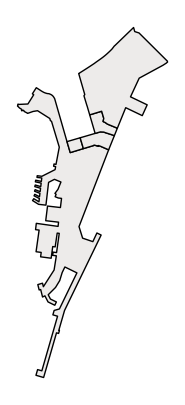

In [160]:
import geopandas as gpd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
selected_tracts_gdf.plot(ax=ax, color='#EDEBEA', edgecolor='black', alpha=1,)
ax.axis('off')

plt.savefig('./figures/adjacency_expl.png', dpi=300, bbox_inches='tight')

plt.show()


Double-check that this worked well

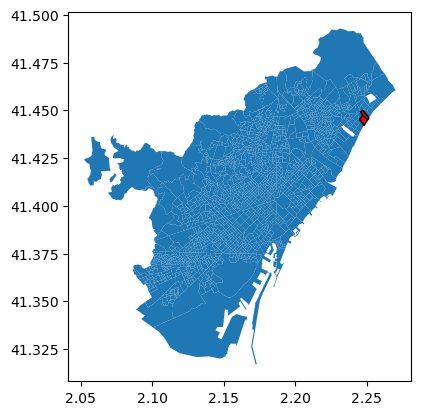

In [300]:
import geopandas as gpd
import matplotlib.pyplot as plt

gdf.plot()
selected_tracts_gdf = gdf.loc[0:1]
selected_tracts_gdf.plot(color='red', edgecolor='black', ax=plt.gca())
plt.show()

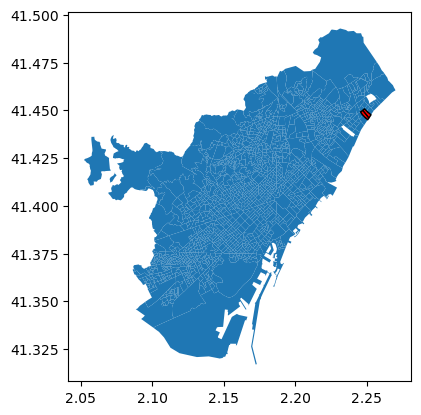

In [301]:
import geopandas as gpd
import matplotlib.pyplot as plt

gdf.plot()
selected_tracts_gdf = gdf.loc[1:2]
selected_tracts_gdf.plot(color='red', edgecolor='black', ax=plt.gca())
plt.show()

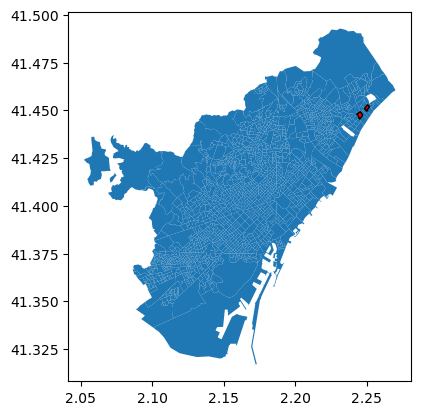

In [302]:
import geopandas as gpd
import matplotlib.pyplot as plt

gdf.plot()
selected_tracts_gdf = gdf.loc[4:5]
selected_tracts_gdf.plot(color='red', edgecolor='black', ax=plt.gca())
plt.show()